In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

In [2]:
#labeling column names for the txt file that will be brought in
colnames=['date','page_viewed','user_id','cohort_id','ip']

#bringing in the txt file
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames, #will be labeling the the columns the names above
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,2,3,4,5] #only using these specified columns
)
df

,date,page_viewed,user_id,cohort_id,ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...
719454,2020-11-02,javascript-i/coffee-project,763,62.0,107.192.148.199
719455,2020-11-02,javascript-i/mapbox-api,771,62.0,172.125.226.175
719456,2020-11-02,javascript-i/coffee-project,771,62.0,172.125.226.175
719457,2020-11-02,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175


In [3]:
#looking to see how many cohort id's there are
df.cohort_id.value_counts()
len(df.cohort_id.value_counts())

40

In [4]:
len(df.ip.value_counts())


4339

In [5]:
df = df.dropna() #dropping all nulls
df.cohort_id = df.cohort_id.astype('int') #changing the column cohort_id to an integer
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674618 entries, 0 to 719458
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   date         674618 non-null  object
 1   page_viewed  674618 non-null  object
 2   user_id      674618 non-null  int64 
 3   cohort_id    674618 non-null  int64 
 4   ip           674618 non-null  object
dtypes: int64(2), object(3)
memory usage: 30.9+ MB
None


,date,page_viewed,user_id,cohort_id,ip
0,2018-01-26,/,1,8,97.105.19.61
1,2018-01-26,java-ii,1,8,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61


In [6]:
df.page_viewed.value_counts()

/                                       36074
javascript-i                            13912
search/search_index.json                13602
toc                                     13413
java-iii                                10614
                                        ...  
quizes                                      1
html-css/css-ii/boostrap-grid-system        1
3-vocabulary                                1
ml-ltc                                      1
classification/project-old-exec             1
Name: page_viewed, Length: 2060, dtype: int64

In [7]:
df.groupby('cohort_id')

In [8]:
#converting the date column to date time
df['date'] = pd.to_datetime(df.date) 

#removing nulls
df = df.dropna()
df.shape

(674618, 5)

In [9]:
df_agg = df.groupby(['date','cohort_id'])['user_id'].\
                        nunique().\
                    reset_index().\
                    rename(index=str, 
                       columns={'user_id': 'users_viewed'})

In [10]:
df_agg

,date,cohort_id,users_viewed
0,2018-01-26,1,1
1,2018-01-26,8,1
2,2018-01-26,13,1
3,2018-01-26,16,2
4,2018-01-26,18,1
...,...,...,...
9622,2020-11-02,57,1
9623,2020-11-02,58,10
9624,2020-11-02,59,17
9625,2020-11-02,61,14


### EMA

In [11]:
cohorts = list(df_agg.cohort_id.unique())
cohorts

[1,
 8,
 13,
 16,
 18,
 19,
 21,
 22,
 14,
 15,
 7,
 4,
 12,
 17,
 23,
 2,
 9,
 11,
 24,
 25,
 26,
 6,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 51,
 52,
 53,
 55,
 56,
 57,
 5,
 58,
 59,
 61,
 62]

In [12]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9627 entries, 0 to 9626
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          9627 non-null   datetime64[ns]
 1   cohort_id     9627 non-null   int64         
 2   users_viewed  9627 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 300.8+ KB


In [13]:
df = df_agg.set_index('date').\
            rename(index=str, columns={'users_viewed':'ema'})

In [14]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev*3
    ema['lb'] = ema.ema - ema.stdev*3
    ema["cohort_name"] = df.cohort_id
    return ema.reset_index()

In [15]:
bands = []
for cohort in cohorts:
    bb = bollinger_bands(df[df.cohort_id == cohort])
    bands.append(bb)

df2 = pd.concat(bands)

In [16]:
df2.head()

,date,cohort_id,ema,stdev,ub,lb,cohort_name
0,2018-01-26 00:00:00,1.0,1.000000,NaN,NaN,NaN,1
1,2018-01-29 00:00:00,1.0,1.266667,NaN,NaN,NaN,1
2,2018-01-30 00:00:00,1.0,1.364444,NaN,NaN,NaN,1
3,2018-01-31 00:00:00,1.0,1.449185,NaN,NaN,NaN,1
4,2018-02-01 00:00:00,1.0,1.389294,NaN,NaN,NaN,1


In [17]:
df2.isnull().sum()

date             0
cohort_id        0
ema              0
stdev          482
ub             482
lb             482
cohort_name      0
dtype: int64

In [18]:
df_missing = df2[df2.stdev.isnull()][['cohort_id','ema']]
df_missing.head()

,cohort_id,ema
0,1.0,1.000000
1,1.0,1.266667
2,1.0,1.364444
3,1.0,1.449185
4,1.0,1.389294


In [19]:
df_missing = df_missing.groupby('cohort_id').std().fillna(value=0).reset_index().rename(index=str, columns={'ema': 'stdev_null'})
df_missing.head()
df.head()

,cohort_id,ema
date,,
2018-01-26 00:00:00,1,1
2018-01-26 00:00:00,8,1
2018-01-26 00:00:00,13,1
2018-01-26 00:00:00,16,2
2018-01-26 00:00:00,18,1


In [20]:
df = df2.merge(df_missing, on='cohort_id', how='left')

In [21]:
df.head()

,date,cohort_id,ema,stdev,ub,lb,cohort_name,stdev_null
0,2018-01-26 00:00:00,1.0,1.000000,NaN,NaN,NaN,1,0.212673
1,2018-01-29 00:00:00,1.0,1.266667,NaN,NaN,NaN,1,0.212673
2,2018-01-30 00:00:00,1.0,1.364444,NaN,NaN,NaN,1,0.212673
3,2018-01-31 00:00:00,1.0,1.449185,NaN,NaN,NaN,1,0.212673
4,2018-02-01 00:00:00,1.0,1.389294,NaN,NaN,NaN,1,0.212673


In [22]:
idx = df.stdev.isnull()
df.loc[idx,'stdev'] = df.loc[idx,'stdev_null']
df = df.drop(columns='stdev_null')
df.head()

,date,cohort_id,ema,stdev,ub,lb,cohort_name
0,2018-01-26 00:00:00,1.0,1.000000,0.212673,NaN,NaN,1
1,2018-01-29 00:00:00,1.0,1.266667,0.212673,NaN,NaN,1
2,2018-01-30 00:00:00,1.0,1.364444,0.212673,NaN,NaN,1
3,2018-01-31 00:00:00,1.0,1.449185,0.212673,NaN,NaN,1
4,2018-02-01 00:00:00,1.0,1.389294,0.212673,NaN,NaN,1


In [23]:
idx = df.ub.isnull()
df.loc[idx,'ub'] = df.loc[idx,'ema'] + df.loc[idx,'stdev']*3
df.loc[idx,'lb'] = df.loc[idx,'ema'] - df.loc[idx,'stdev']*3
df.head()

,date,cohort_id,ema,stdev,ub,lb,cohort_name
0,2018-01-26 00:00:00,1.0,1.000000,0.212673,1.638018,0.361982,1
1,2018-01-29 00:00:00,1.0,1.266667,0.212673,1.904685,0.628648,1
2,2018-01-30 00:00:00,1.0,1.364444,0.212673,2.002463,0.726426,1
3,2018-01-31 00:00:00,1.0,1.449185,0.212673,2.087204,0.811167,1
4,2018-02-01 00:00:00,1.0,1.389294,0.212673,2.027312,0.751275,1


In [24]:
idx = df.ub == df.lb
df.loc[idx,'ub'] = df.loc[idx,'ub'] + .01
df.loc[idx,'lb'] = df.loc[idx,'lb'] - .01

In [25]:
df.date = pd.to_datetime(df.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9627 entries, 0 to 9626
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         9627 non-null   datetime64[ns]
 1   cohort_id    9627 non-null   float64       
 2   ema          9627 non-null   float64       
 3   stdev        9627 non-null   float64       
 4   ub           9627 non-null   float64       
 5   lb           9627 non-null   float64       
 6   cohort_name  9627 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 601.7 KB


In [26]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9627 entries, 0 to 9626
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          9627 non-null   datetime64[ns]
 1   cohort_id     9627 non-null   int64         
 2   users_viewed  9627 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 300.8+ KB


In [27]:
df = df.merge(df_agg, on=['cohort_id','date'], how='left')

In [28]:
df.head()

,date,cohort_id,ema,stdev,ub,lb,cohort_name,users_viewed
0,2018-01-26,1.0,1.000000,0.212673,1.638018,0.361982,1,1
1,2018-01-29,1.0,1.266667,0.212673,1.904685,0.628648,1,3
2,2018-01-30,1.0,1.364444,0.212673,2.002463,0.726426,1,2
3,2018-01-31,1.0,1.449185,0.212673,2.087204,0.811167,1,2
4,2018-02-01,1.0,1.389294,0.212673,2.027312,0.751275,1,1


In [29]:
df['pct_b'] = (df.users_viewed-df.lb)/(df.ub-df.lb)
df = df.drop(columns=['stdev','cohort_id'])
df.head()

,date,ema,ub,lb,cohort_name,users_viewed,pct_b
0,2018-01-26,1.000000,1.638018,0.361982,1,1,0.500000
1,2018-01-29,1.266667,1.904685,0.628648,1,3,1.858372
2,2018-01-30,1.364444,2.002463,0.726426,1,2,0.998070
3,2018-01-31,1.449185,2.087204,0.811167,1,2,0.931661
4,2018-02-01,1.389294,2.027312,0.751275,1,1,0.194920


In [30]:
df[df.pct_b>1].sort_values(by='pct_b', ascending=False)

,date,ema,ub,lb,cohort_name,users_viewed,pct_b
3209,2018-11-05,1.909928,2.261775,1.558080,23,5,4.891207
1509,2020-03-27,1.138853,1.239994,1.037713,21,2,4.757169
1043,2018-07-11,1.140681,1.241638,1.039724,19,2,4.755855
3473,2020-09-06,1.138598,1.239835,1.037361,23,2,4.754392
2275,2018-11-07,1.138224,1.239632,1.036816,14,2,4.749037
...,...,...,...,...,...,...,...
3014,2018-04-13,16.253705,19.993330,12.514079,23,20,1.000892
163,2018-08-22,2.765885,2.999736,2.532034,1,3,1.000564
4220,2018-10-19,15.488529,17.997609,12.979449,26,18,1.000476
5646,2019-05-02,16.674237,19.997245,13.351230,29,20,1.000414


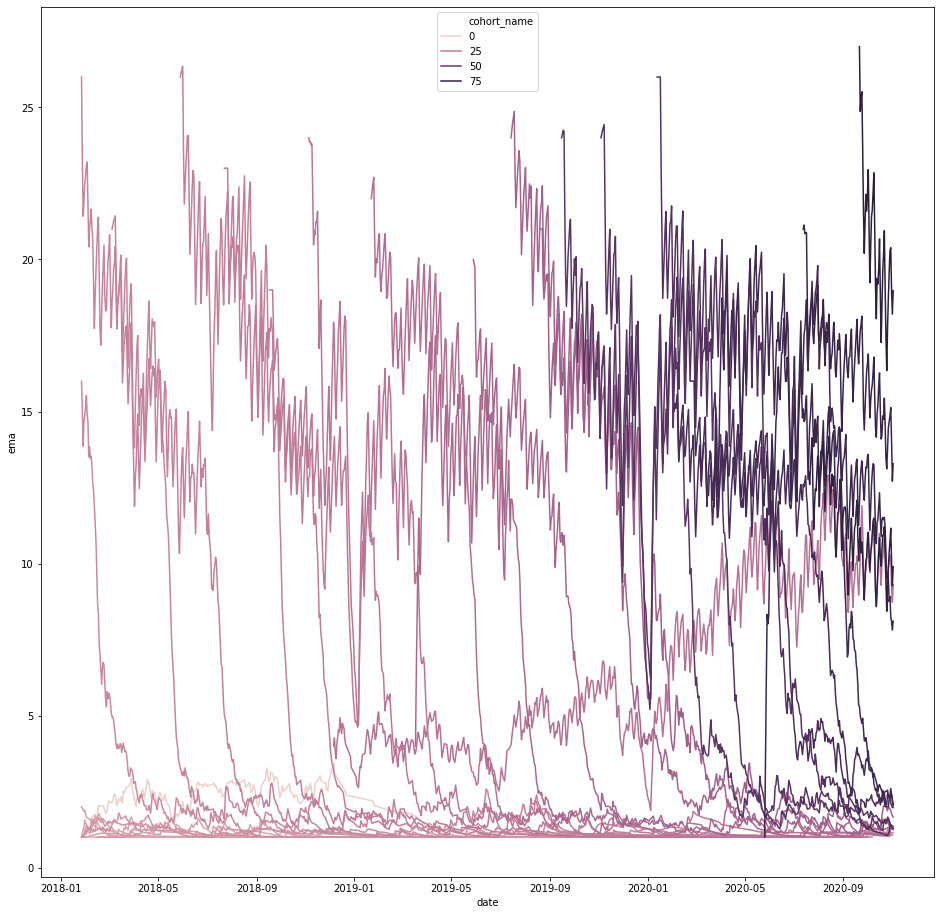

In [31]:
# plot the 7 day exponential moving average
fig = plt.figure(figsize=(16,16))
sns.lineplot(df.date, df.ema, hue=df.cohort_name)

# Random Exploring

In [48]:
#labeling column names for the txt file that will be brought in
colnames=['date','page_viewed','user_id','cohort_id','ip']

#bringing in the txt file
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames, #will be labeling the the columns the names above
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,2,3,4,5] #only using these specified columns
)
df

,date,page_viewed,user_id,cohort_id,ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...
719454,2020-11-02,javascript-i/coffee-project,763,62.0,107.192.148.199
719455,2020-11-02,javascript-i/mapbox-api,771,62.0,172.125.226.175
719456,2020-11-02,javascript-i/coffee-project,771,62.0,172.125.226.175
719457,2020-11-02,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175


In [51]:
df.date = pd.to_datetime(df.date)
df = df.set_index('date').sort_index()
df

,page_viewed,user_id,cohort_id,ip
date,,,,
2018-01-26,/,1,8.0,97.105.19.61
2018-01-26,java-ii,1,8.0,97.105.19.61
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...
2020-11-02,javascript-i/coffee-project,763,62.0,107.192.148.199
2020-11-02,javascript-i/mapbox-api,771,62.0,172.125.226.175
2020-11-02,javascript-i/coffee-project,771,62.0,172.125.226.175


In [56]:
df['ip'].str.contains('96.8.130.240', na=False)

date
2018-01-26    False
2018-01-26    False
2018-01-26    False
2018-01-26    False
2018-01-26    False
              ...  
2020-11-02    False
2020-11-02    False
2020-11-02    False
2020-11-02    False
2020-11-02    False
Name: ip, Length: 719459, dtype: bool

In [57]:
print(df[df['ip'] == '96.8.130.240'])

                                         page_viewed  user_id  cohort_id  \
date                                                                       
2020-05-13                                         /      483       34.0   
2020-05-13  1-fundamentals/1.1-intro-to-data-science      483       34.0   
2020-05-13  1-fundamentals/modern-data-scientist.jpg      483       34.0   
2020-05-13      1-fundamentals/AI-ML-DL-timeline.jpg      483       34.0   
2020-05-13  1-fundamentals/1.2-data-science-pipeline      483       34.0   
...                                              ...      ...        ...   
2020-10-29                          regression/model      694       59.0   
2020-10-29               timeseries/modeling-lesson1      694       59.0   
2020-10-29                        timeseries/explore      694       59.0   
2020-10-29                regression/split-and-scale      694       59.0   
2020-10-30               timeseries/modeling-lesson1      694       59.0   

           